# Natural Language Processing with Disaster Tweets
Rafiq Premji - CSCA 5642

## Step 1: Descriptions

### Problem Description
The goal of this challenge is to classify tweets as being about a real disaster or not. It's a binary classification problem using Natural Language Processing techniques, where the model predicts `1` if the tweet describes a real disaster and `0` otherwise.

### Data Description
The dataset is two sets of tweets, structured in a tabular format and contained CSV files.
- train.csv contains 8561 rows with the columns:
    - `id`: A unique identifier for each tweet.
    - `keyword`: (optional) A single keyword from the tweet.
    - `location`: (optional) The tweeter's provided location.
    - `text`: The actual content of the tweet.
    - `target`: The target variable (1 means the tweet describes a disaster, and 0 if not).
- test.csv contains 3699 rows of the exact same columns other than `target`.

In [112]:
# import everything

import itertools
import re
import string
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from keras.src.saving import load_model
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Step 2: Exploratory Data Analysis (EDA)

In [2]:
# load data

base_path = 'data/'
train_df = pd.read_csv(base_path+'train.csv')
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [3]:
print(f"Data shape: {train_df.shape}")
print(train_df.info())

Data shape: (7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [4]:
# check for missing values

missing_values = train_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


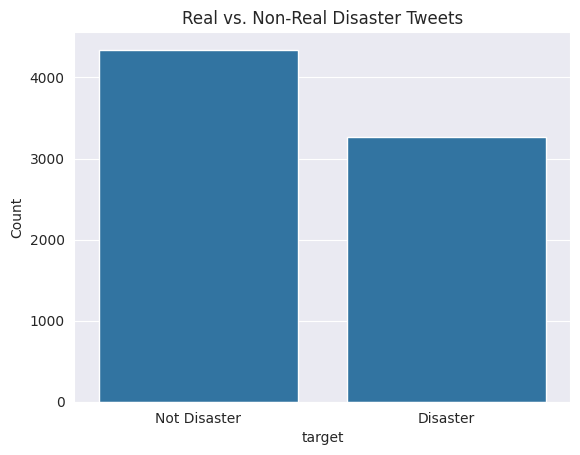

Percentage:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


In [5]:
# plot label distribution

sns.countplot(x='target', data=train_df)
plt.title('Real vs. Non-Real Disaster Tweets')
plt.xticks([0,1], ["Not Disaster","Disaster"])
plt.ylabel('Count')
plt.show()

target_counts = train_df['target'].value_counts(normalize=True)*100
print(f"Percentage:\n{target_counts}")

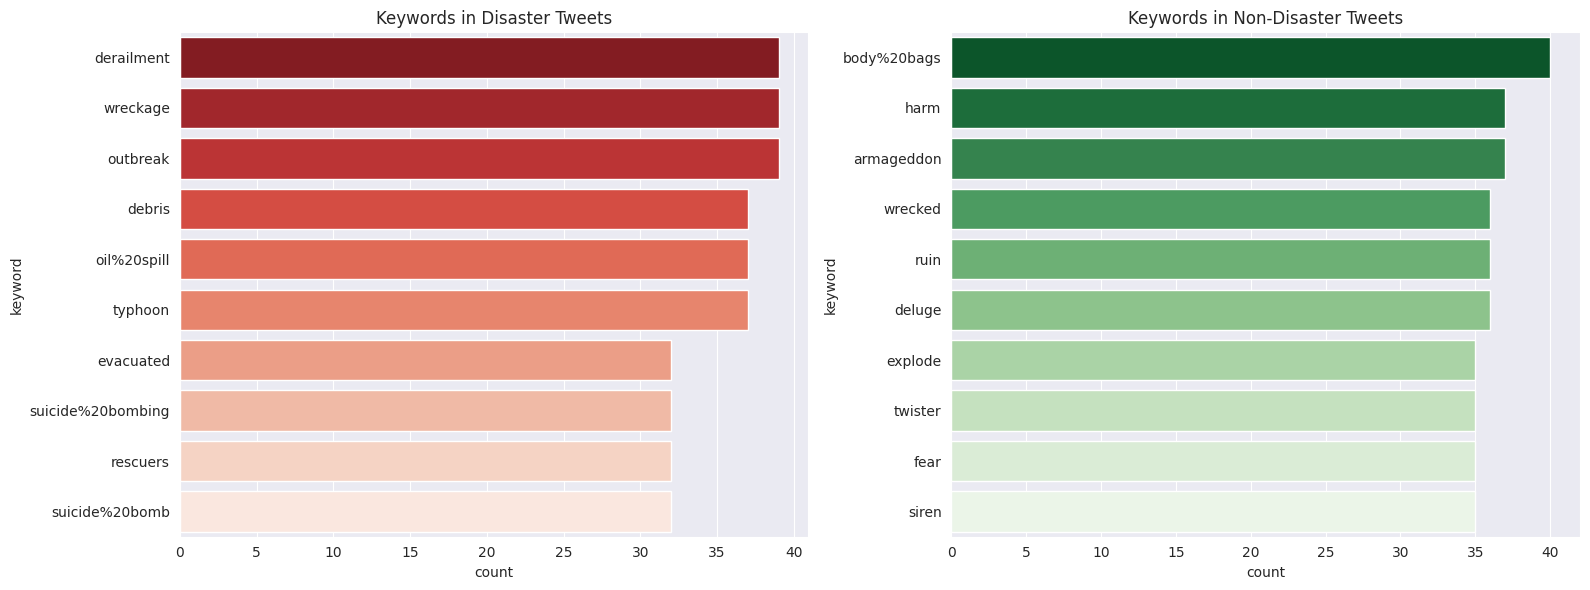

In [6]:
# plot the top keywords in each type of tweet

fig, axes = plt.subplots(1,2, figsize=(16,6))

disaster_y = train_df[train_df['target']==1]['keyword'].value_counts()[:10].index
sns.barplot(y=disaster_y, x=train_df[train_df['target']==1]['keyword'].value_counts()[:10], ax=axes[0], palette='Reds_r', hue=disaster_y)
axes[0].set_title('Keywords in Disaster Tweets')

non_y = train_df[train_df['target']==0]['keyword'].value_counts()[:10].index
sns.barplot(y=non_y, x=train_df[train_df['target']==0]['keyword'].value_counts()[:10], ax=axes[1], palette='Greens_r', hue=non_y)
axes[1].set_title('Keywords in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

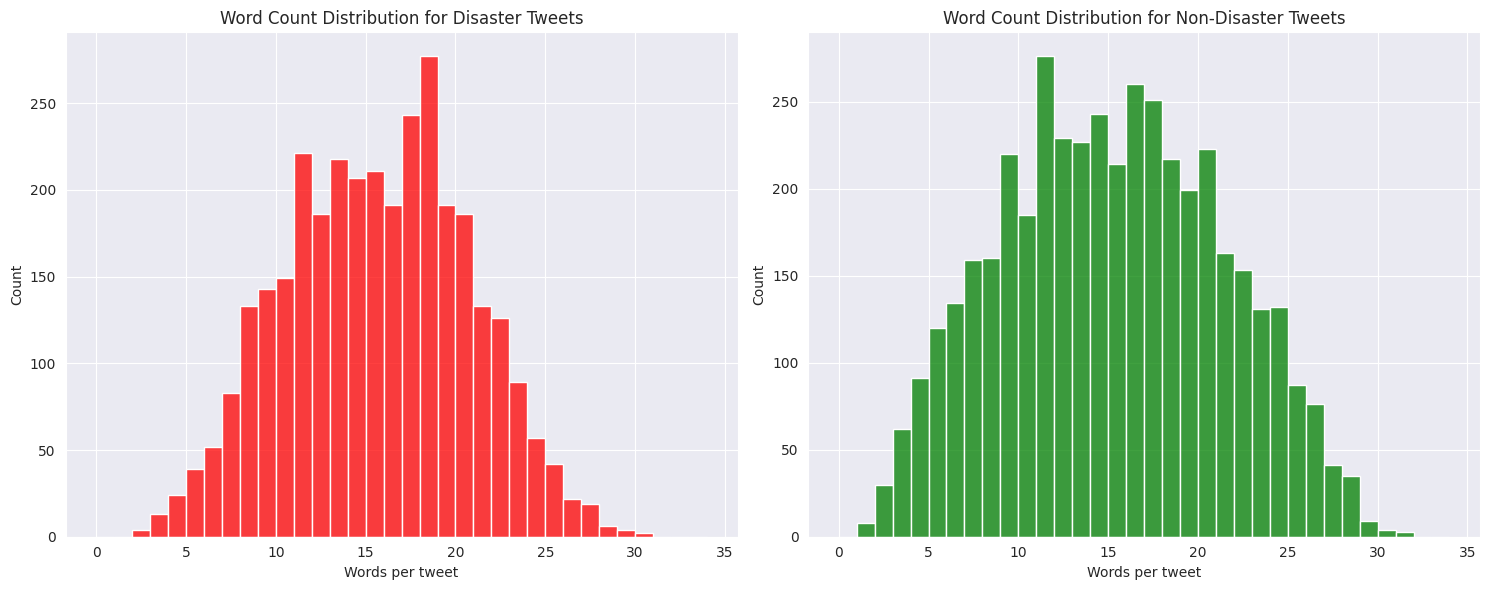

In [7]:
# plot tweet word count distribution

train_df['tweet_length'] = train_df['text'].apply(lambda x: len(x))
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
bins = range(0, 35)

sns.histplot(train_df[train_df['target']==1]['word_count'], bins=bins, color='red', label='Disaster', ax=axes[0])
axes[0].set_title('Word Count Distribution for Disaster Tweets')
axes[0].set_xlabel('Words per tweet')

sns.histplot(train_df[train_df['target']==0]['word_count'], bins=bins, color='green', label='Non-disaster', ax=axes[1])
axes[1].set_title('Word Count Distribution for Non-Disaster Tweets')
axes[1].set_xlabel('Words per tweet')

plt.tight_layout()
plt.show()

In [8]:
# non-disaster tweets are slightly shorter
print(f"Average number of words per disaster tweet: {train_df[train_df['target']==1]['word_count'].mean()}")
print(f"Average number of words per non-disaster tweet: {train_df[train_df['target']==0]['word_count'].mean()}")

Average number of words per disaster tweet: 15.167532864567411
Average number of words per non-disaster tweet: 14.704744357438969


### Data Cleaning

In [118]:
# remove rows with missing values
clean_df = train_df.drop(columns=['keyword', 'location', 'tweet_length', 'word_count'])
clean_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [119]:
# no duplicate rows
print("Duplicated rows:", clean_df.duplicated().sum())

Duplicated rows: 0


In [120]:
# I want to filter out everything non-essential from tweets

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def clean_tweet(tweet):
    # lowercase
    tweet = tweet.lower()
    # URLs
    tweet = re.sub(r"http\S+|www.\S+", "", tweet)
    # @mention and # char
    tweet = re.sub(r"@\w+", "", tweet)
    tweet = re.sub(r"#", "", tweet)
    # emojis
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    # punctuation
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    # numbers
    tweet = re.sub(r'\d+', '', tweet)
    # remove stop words
    tokens = tweet.split()
    tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /home/rafiq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Plan of Analysis:
Based on initial EDA, my findings and plan are:

- The dataset is relatively small and well-balanced.
- I'm simplifying things by removing columns with optional values (keyword, location).
- Some sort of text preprocessing will need to be done like cleaning, removing special chars like hashtags and stop words.
- I've used word embedding in the past but am not deeply familiar with the various techniques so am going to research the three suggested methods to see how they compare then pick one: TF-IDF, GloVe, Word2Vec.
- After running embeddings I will feed the transformed data into LSTM and GRU architectures and compare their results.
- Hyperparameter tuning (learning rate, sequence length, embedding dimensions, types of embedding, dropout rates) will be explored.
- Performance will be measured based on F1 score of validation data.

## Step 3: Model Architecture

### Why RNN?
Tweets are ordered sequences of words so the meaning of a word depends on those that precede and sometimes follow it. Recurrent neural networks, especially the modern gated variants (LSTM & GRU) are designed exactly for this because they process tokens in order and keep a hidden state that can hold context. The gated units mitigate vanishing/explodient gradients that commonly appear when dealing with many time steps earlier, which can be important when a keyword flips or modifies a previous word or sentiment.

### Text Embedding
Embedding is the process of converting blobs of text into numbers/vectors so they can be fet into machine learning models for processing. After doing research on popular embedding techniques I came away with this info:
- **TF-IDF (term frequency-inverse document frequency):** Computes vectors based on how frequently terms appear relative to their rarity across the entire corpus.
- **GloVe (global vectors):** Trains an unsupervised learning model to look for word-to-word co-occurrence across local and global context to extract semantic meanings. Is more focused on global text.
- **Word2Vec:** Trains a shallow neural network to pull linguistic context out of words, and produces a map of meaning. Is more focused on local context.

Based on the above, Word2Vec seemed like the most appropriate choice since the tweets being analyzed are very short fragments of text so local context is all that matters when doing sentiment analysis.

### Models
- **LSTM**: Embedding Layer followed by Two LSTM Layers each followed by dropout, ending with a Dense Layer for the final classification.
- **GRU**: Embedding Layer followed by Two GRU Layers followed by a single dropout, also ending with a Dense Layer for final classification.

In [12]:
# split data into training/validation

X = clean_df["text"].values
y = clean_df["target"].values

# clean data before splitting
X_cleaned = [clean_tweet(tweet) for tweet in X]

X_train, X_val, y_train, y_val = train_test_split(X_cleaned, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))

Training samples: 6090
Validation samples: 1523


In [13]:
# tokenization and padding

max_tokens = 30
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_tokens, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_tokens, padding='post', truncating='post')

print(X_train_padded.shape)
print(X_val_padded.shape)

(6090, 30)
(1523, 30)


In [35]:
# pretrain word2vec models at various dimensions for hyperparameter tuning

train_sentences = [tweet.split() for tweet in X_train]

def generate_embedding_matrix(embedding_dimension):
    model = Word2Vec(sentences=train_sentences, vector_size=embedding_dimension, window=3, min_count=1, workers=4, seed=42)
    embedding_matrix = np.zeros((vocab_size, embedding_dimension))

    for word, i in tokenizer.word_index.items():
        if i < vocab_size:
            embedding_vector = model.wv.get_vector(word, norm=True) if word in model.wv else None
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

pretrained_embeddings = {}
for embedding_dim in [50, 100, 200]:
    pretrained_embeddings[embedding_dim] = generate_embedding_matrix(embedding_dim)

In [15]:
# create lstm model

def build_lstm_model(vocab_size, embedding_dim, embedding_matrix, lstm_units, dropout_rate, learning_rate, trainable_embedding=False):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=trainable_embedding),
        LSTM(lstm_units[0], return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units[1]),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [16]:
# create GRU model

def build_gru_model(vocab_size, embedding_dim, embedding_matrix, gru_units, dropout_rate, learning_rate, trainable_embedding=False):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=trainable_embedding),
        GRU(gru_units[0], return_sequences=True),
        Dropout(dropout_rate),
        GRU(gru_units[1]),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [43]:
# hyperparameter tuning
# these models run pretty fast on my computer so I can try a wider range of params than last project

hyperparameter_grid = {
    'units': [[32, 16], [64, 32], [128, 64]],
    'dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'learning_rate': [5e-3, 1e-3, 5e-4, 1e-4],
    'trainable_embedding': [False, True],
    'embedding_dim': [50, 100],
}

def evaluate_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    y_val_pred_prob = model.predict(X_val).ravel()
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    return acc, f1

def grid_search(model_type, builder_function, hyperparameter_grid, build_kwargs_base, X_train, y_train, X_val, y_val):
    results = []
    hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

    run_number = 0
    for hyperparam_set in hyperparameter_combinations:
        run_number += 1
        hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparam_set))
        print(f"Run {run_number} of {len(hyperparameter_combinations)} for {model_type} with params: {hyperparam_dict}")

        # merge hyperparams
        kwargs = build_kwargs_base.copy()
        kwargs.update({
            'dropout_rate': hyperparam_dict['dropout_rate'],
            'learning_rate': hyperparam_dict['learning_rate'],
            'trainable_embedding': hyperparam_dict['trainable_embedding'],
            'embedding_dim': hyperparam_dict['embedding_dim'],
            'embedding_matrix': pretrained_embeddings[hyperparam_dict['embedding_dim']]
        })
        if model_type == 'LSTM':
            kwargs.update({'lstm_units': hyperparam_dict['units']})
        elif model_type == 'GRU':
            kwargs.update({'gru_units': hyperparam_dict['units']})

        # build and evaluate model
        model = builder_function(**kwargs)
        acc, f1 = evaluate_model(model, X_train, y_train, X_val, y_val)

        # record results
        result_entry = {
            'model_type': model_type,
            'units': hyperparam_dict['units'],
            'dropout_rate': hyperparam_dict['dropout_rate'],
            'learning_rate': hyperparam_dict['learning_rate'],
            'trainable_embedding': hyperparam_dict['trainable_embedding'],
            'embedding_dim': hyperparam_dict['embedding_dim'],
            'accuracy': acc,
            'f1_score': f1
        }
        print(f"Accuracy: {acc:.3f}, F1-score: {f1:.3f}")
        results.append(result_entry)

    return pd.DataFrame(results)

In [17]:
build_kwargs_base = {
    'vocab_size': vocab_size,
}

# run grid search on both models
results_lstm_df = grid_search('LSTM', build_lstm_model, hyperparameter_grid, build_kwargs_base, X_train_padded, y_train, X_val_padded, y_val)
results_gru_df = grid_search('GRU', build_gru_model, hyperparameter_grid, build_kwargs_base, X_train_padded, y_train, X_val_padded, y_val)
results_df = pd.concat([results_lstm_df, results_gru_df])
results_df.sort_values('f1_score', ascending=False)

Run 1 of 192 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'learning_rate': 0.005, 'trainable_embedding': False, 'embedding_dim': 50}


I0000 00:00:1747801489.750182  398200 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6249 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1747801492.091579  398368 cuda_dnn.cc:529] Loaded cuDNN version 91001


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.692, F1-score: 0.629
Run 2 of 192 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'learning_rate': 0.005, 'trainable_embedding': False, 'embedding_dim': 100}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.737, F1-score: 0.680
Run 3 of 192 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'learning_rate': 0.005, 'trainable_embedding': True, 'embedding_dim': 50}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.758, F1-score: 0.713
Run 4 of 192 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'learning_rate': 0.005, 'trainable_embedding': True, 'embedding_dim': 100}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.754, F1-score: 0.716
Run 5 of 192 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'learning_rate': 0.001, 'trainable_embedding': False, 'embedding_dim': 50}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.715, F1-score: 0.600
Run 6 of 192 for LSTM with params: {

,model_type,units,dropout_rate,learning_rate,trainable_embedding,embedding_dim,accuracy,f1_score
30,GRU,"[32, 16]",0.2,0.0001,True,50,0.793171,0.766839
47,GRU,"[32, 16]",0.3,0.0001,True,100,0.795141,0.762195
14,GRU,"[32, 16]",0.1,0.0001,True,50,0.806960,0.760976
46,GRU,"[32, 16]",0.3,0.0001,True,50,0.806303,0.757998
15,GRU,"[32, 16]",0.1,0.0001,True,100,0.791202,0.755760
...,...,...,...,...,...,...,...,...
161,LSTM,"[128, 64]",0.3,0.0050,False,100,0.570584,0.000000
177,LSTM,"[128, 64]",0.5,0.0050,False,100,0.570584,0.000000
65,LSTM,"[64, 32]",0.1,0.0050,False,100,0.570584,0.000000
48,LSTM,"[32, 16]",0.5,0.0050,False,50,0.570584,0.000000


## Step 4: Results and Analysis

In [37]:
# the top 10 performing parameter configs are all GRU
results_df.sort_values('f1_score', ascending=False)

,model_type,units,dropout_rate,learning_rate,trainable_embedding,embedding_dim,accuracy,f1_score
30,GRU,"[32, 16]",0.2,0.0001,True,50,0.793171,0.766839
47,GRU,"[32, 16]",0.3,0.0001,True,100,0.795141,0.762195
14,GRU,"[32, 16]",0.1,0.0001,True,50,0.806960,0.760976
46,GRU,"[32, 16]",0.3,0.0001,True,50,0.806303,0.757998
15,GRU,"[32, 16]",0.1,0.0001,True,100,0.791202,0.755760
...,...,...,...,...,...,...,...,...
161,LSTM,"[128, 64]",0.3,0.0050,False,100,0.570584,0.000000
177,LSTM,"[128, 64]",0.5,0.0050,False,100,0.570584,0.000000
65,LSTM,"[64, 32]",0.1,0.0050,False,100,0.570584,0.000000
48,LSTM,"[32, 16]",0.5,0.0050,False,50,0.570584,0.000000


In [25]:
# let's look at the top 5 of each model

top5_gru = results_df[results_df['model_type'] == 'GRU'] \
    .sort_values('f1_score', ascending=False) \
    .head(5)
top5_lstm = results_df[results_df['model_type'] == 'LSTM'] \
    .sort_values('f1_score', ascending=False) \
    .head(5)
top5_each_model = pd.concat([top5_gru, top5_lstm]).reset_index(drop=True)

display(top5_each_model)

,model_type,units,dropout_rate,learning_rate,trainable_embedding,embedding_dim,accuracy,f1_score
0,GRU,"[32, 16]",0.2,0.0001,True,50,0.793171,0.766839
1,GRU,"[32, 16]",0.3,0.0001,True,100,0.795141,0.762195
2,GRU,"[32, 16]",0.1,0.0001,True,50,0.806960,0.760976
3,GRU,"[32, 16]",0.3,0.0001,True,50,0.806303,0.757998
4,GRU,"[32, 16]",0.1,0.0001,True,100,0.791202,0.755760
5,LSTM,"[32, 16]",0.3,0.0001,True,50,0.785949,0.740032
6,LSTM,"[64, 32]",0.5,0.0001,True,50,0.764281,0.736223
7,LSTM,"[32, 16]",0.5,0.0001,True,100,0.766907,0.734082
8,LSTM,"[32, 16]",0.2,0.0001,True,50,0.776756,0.732283
9,LSTM,"[32, 16]",0.3,0.0001,True,100,0.769534,0.731446


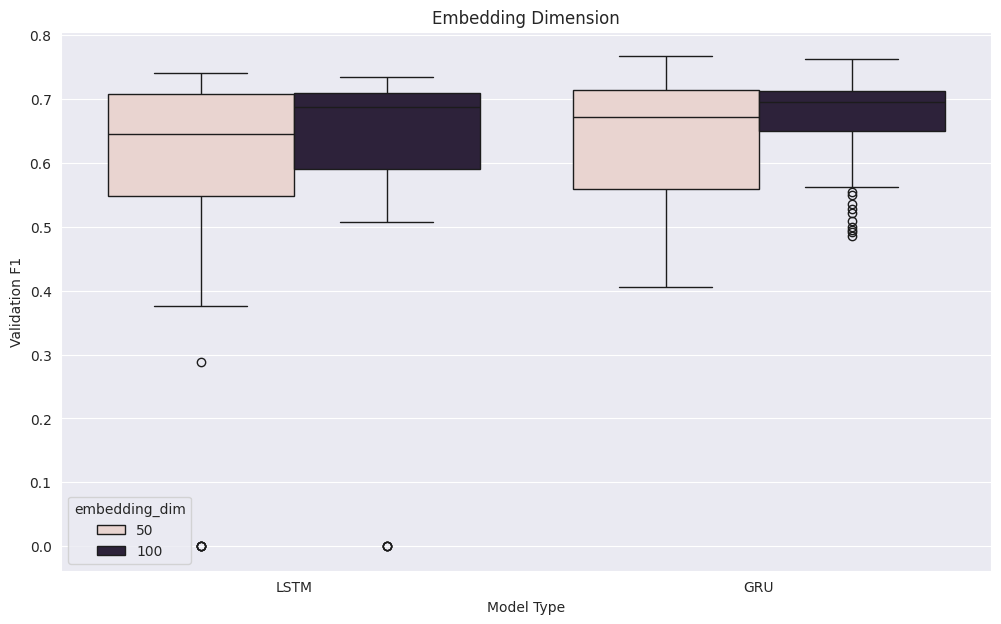

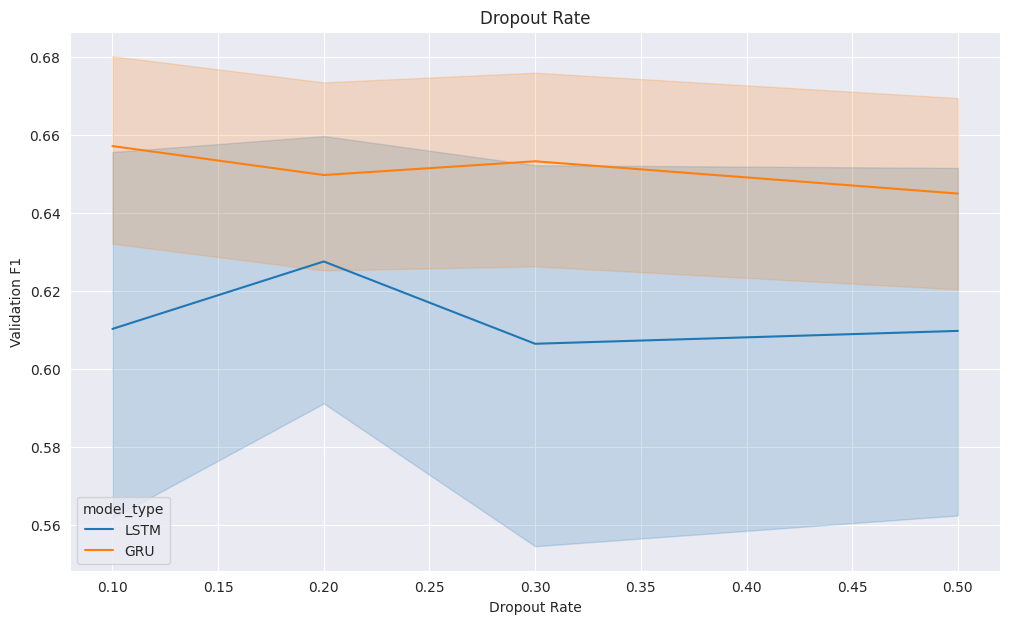

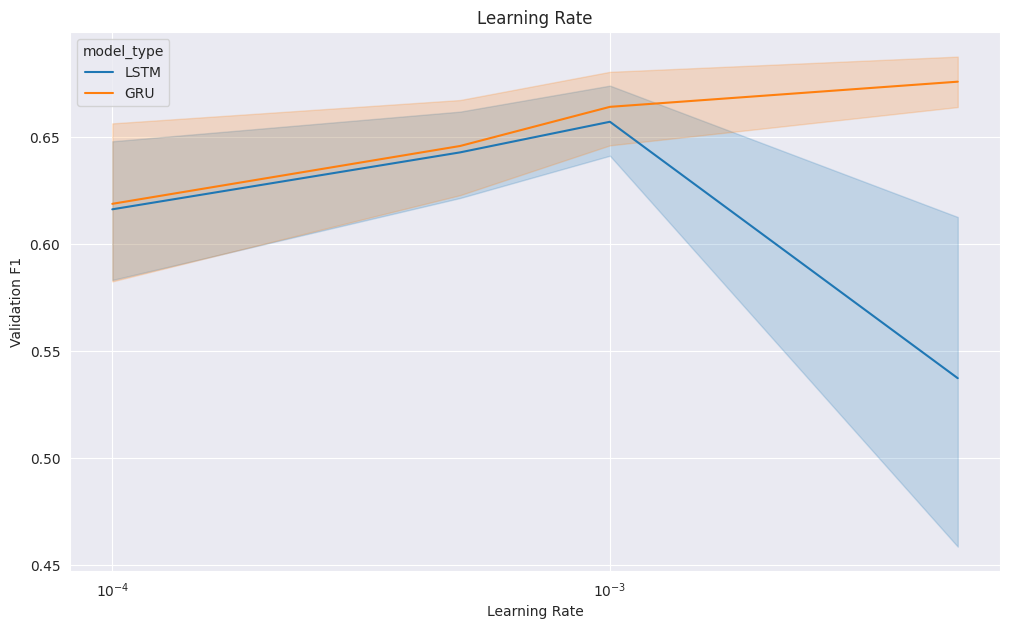

In [32]:
# plot F1 score by model type vs different hyperparameters

# embedding dimension
plt.figure(figsize=(12,7))
sns.boxplot(data=results_df, x='model_type', y='f1_score', hue='embedding_dim')
plt.title("Embedding Dimension")
plt.ylabel("Validation F1")
plt.xlabel("Model Type")
plt.show()

# dropout rate
plt.figure(figsize=(12,7))
sns.lineplot(data=results_df, x='dropout_rate', y='f1_score', hue='model_type')
plt.title("Dropout Rate")
plt.ylabel("Validation F1")
plt.xlabel("Dropout Rate")
plt.show()

# learning rate
plt.figure(figsize=(12,7))
sns.lineplot(data=results_df, x='learning_rate', y='f1_score', hue='model_type')
plt.xscale('log')
plt.title("Learning Rate")
plt.ylabel("Validation F1")
plt.xlabel("Learning Rate")
plt.show()

### Hyperparameter Optimization Procedure
To choose the best hyperparameters I performed a basic grid search on some values that looked reasonable and used F1 score as the metric when deciding which parameters to choose. After my first optimization run I found the following params performed best:
- Model: GRU
- Units: 32,16
- Dropout Rate: 20%
- Learning Rate: 0.0001
- Trainable Embeddings: Yes
- Embedding Dimension: 50
This configuration achieved 79.3% accuracy and 76.7% F1 score on validation data.

### Analysis
GRU performed slightly better than LSTM but after initial hyperparameter grid search, neither was able to break 80% accuracy or 77% F1 score. A higher embedding dimension showed moderate improvements across all models, possibly because it captured deeper semantic meaning between words. However on the top performing models, 50 vs 100 dimensions didn't seem to make a difference maybe due to the limited number of training epochs. Lower dropout rates (0.1-0.2) seemed to perform better because they balanced regularization against losing too much context. For learning rates, moderate values seemed to perform best, with very low rates performing worse due to slow training and high rates being too unstable to converge. Finally, trainable embeddings seemed to universally perform better as all the top performing variants of both models had this parameter enabled.

### Troubleshooting

I'm not sure if 79%/77% is a good result but thought I could do a little better by focusing on training the best parameters for longer epochs. I pared down my hyperparameter grid to fewer values for just: units, dropout rate, embedding dimensions (and added 200 as a value), and also reduced the windows size of Word2Vec to 3 and retrained it. I also created a learning rate scheduler and put it in a new evaluate function that new does 100 epochs, with a new early stopping callback so to reduce wasted training time. Also after digging into the Keras/Tensorflow documentation I realized I was saving the parameters from my final epoch instead of the best training epoch, so I added model checkpoints to counteract that.

In [83]:
new_hyperparameter_grid = {
    'units': [[32, 16], [64, 32]],
    'dropout_rate': [0.1, 0.2, 0.3],
    'embedding_dim': [50, 100, 200],
}

new_kwargs_base = {
    'vocab_size': vocab_size,
    'learning_rate': 0.0001,
    'trainable_embedding': True,
}

In [106]:
# make a learning rate scheduler and new grid search/evaluate function which use it

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=0,
    min_lr=1e-6
)

early_stopping = EarlyStopping(patience=10, verbose=0)

# save the best results from each model
lstm_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_lstm.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0
)
gru_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_gru.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0
)

def new_evaluate_model(model, model_type, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    if model_type == 'LSTM':
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=[lr_scheduler, early_stopping, lstm_checkpoint])
    elif model_type == 'GRU':
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=[lr_scheduler, early_stopping, gru_checkpoint])
    y_val_pred_prob = model.predict(X_val).ravel()
    y_val_pred = (y_val_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    return acc, f1

def new_grid_search(model_type, builder_function, hyperparameter_grid, build_kwargs_base, X_train, y_train, X_val, y_val):
    results = []
    hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

    run_number = 0
    for hyperparam_set in hyperparameter_combinations:
        run_number += 1
        hyperparam_dict = dict(zip(hyperparameter_grid.keys(), hyperparam_set))
        print(f"Run {run_number} of {len(hyperparameter_combinations)} for {model_type} with params: {hyperparam_dict}")

        # merge hyperparams
        kwargs = build_kwargs_base.copy()
        kwargs.update({
            'dropout_rate': hyperparam_dict['dropout_rate'],
            'embedding_dim': hyperparam_dict['embedding_dim'],
            'embedding_matrix': pretrained_embeddings[hyperparam_dict['embedding_dim']]
        })
        if model_type == 'LSTM':
            kwargs.update({'lstm_units': hyperparam_dict['units']})
        elif model_type == 'GRU':
            kwargs.update({'gru_units': hyperparam_dict['units']})

        # build and evaluate model
        model = builder_function(**kwargs)
        acc, f1 = new_evaluate_model(model, model_type, X_train, y_train, X_val, y_val)

        # record results
        result_entry = {
            'model_type': model_type,
            'units': hyperparam_dict['units'],
            'dropout_rate': hyperparam_dict['dropout_rate'],
            'embedding_dim': hyperparam_dict['embedding_dim'],
            'accuracy': acc,
            'f1_score': f1
        }
        print(f"Accuracy: {acc:.3f}, F1-score: {f1:.3f}")
        results.append(result_entry)

    return pd.DataFrame(results)

In [107]:
# run another hyperparameter search

results_lstm_df = new_grid_search('LSTM', build_lstm_model, new_hyperparameter_grid, new_kwargs_base, X_train_padded, y_train, X_val_padded, y_val)
results_gru_df = new_grid_search('GRU', build_gru_model, new_hyperparameter_grid, new_kwargs_base, X_train_padded, y_train, X_val_padded, y_val)
results_df = pd.concat([results_lstm_df, results_gru_df])

Run 1 of 18 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'embedding_dim': 50}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.758, F1-score: 0.727
Run 2 of 18 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'embedding_dim': 100}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.775, F1-score: 0.737
Run 3 of 18 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.1, 'embedding_dim': 200}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.783, F1-score: 0.740
Run 4 of 18 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.2, 'embedding_dim': 50}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.770, F1-score: 0.736
Run 5 of 18 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.2, 'embedding_dim': 100}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.775, F1-score: 0.743
Run 6 of 18 for LSTM with params: {'units': [32, 16], 'dropout_rate': 0.2, 'embedding_dim': 200}
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.775, F1-s

In [110]:
# results are slightly better
results_df.sort_values('f1_score', ascending=False)

,model_type,units,dropout_rate,embedding_dim,accuracy,f1_score
2,GRU,"[32, 16]",0.1,200,0.807617,0.774442
5,GRU,"[32, 16]",0.2,200,0.799737,0.766284
0,GRU,"[32, 16]",0.1,50,0.797768,0.765244
8,GRU,"[32, 16]",0.3,200,0.797111,0.764302
16,GRU,"[64, 32]",0.3,100,0.800394,0.761755
7,GRU,"[32, 16]",0.3,100,0.795798,0.757221
17,GRU,"[64, 32]",0.3,200,0.794485,0.756420
12,GRU,"[64, 32]",0.2,50,0.791858,0.755590
1,GRU,"[32, 16]",0.1,100,0.797768,0.755556
15,GRU,"[64, 32]",0.3,50,0.789888,0.754601


In [113]:
# load the best models from checkpoints and evaluate their performance

best_lstm_model = load_model('best_lstm.keras')
best_gru_model = load_model('best_gru.keras')

best_lstm_model.summary()
best_gru_model.summary()

y_val_pred_lstm = (best_lstm_model.predict(X_val_padded).ravel() >= 0.5).astype(int)
y_val_pred_gru = (best_gru_model.predict(X_val_padded).ravel() >= 0.5).astype(int)

print("LSTM Results:")
print(classification_report(y_val, y_val_pred_lstm))
print(f"LSTM accuracy: {accuracy_score(y_val, y_val_pred_lstm):.4f}")
print(f"LSTM F1-score: {f1_score(y_val, y_val_pred_lstm):.4f}\n")

print("GRU Results:")
print(classification_report(y_val, y_val_pred_gru))
print(f"GRU accuracy: {accuracy_score(y_val, y_val_pred_gru):.4f}")
print(f"GRU F1-score: {f1_score(y_val, y_val_pred_gru):.4f}")

Model: "sequential_500"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_500 (Embedding)       │ (None, 30, 200)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_476 (LSTM)                 │ (None, 30, 64)         │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1000 (Dropout)          │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_477 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1001 (Dropout)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_500 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,240,869 (23.81 MB)

 Trainable params: 2,080,289 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,160,580 (15.87 MB)

Model: "sequential_515"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_515 (Embedding)       │ (None, 30, 200)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_552 (GRU)                   │ (None, 30, 64)         │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1030 (Dropout)          │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_553 (GRU)                   │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1031 (Dropout)          │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_515 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,181,541 (23.58 MB)

 Trainable params: 2,060,513 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,121,028 (15.72 MB)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM Results:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.80      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

LSTM accuracy: 0.8017
LSTM F1-score: 0.7557

GRU Results:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       869
           1       0.81      0.72      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

GRU accuracy: 0.8089
GRU F1-score: 0.7636


### Submit To Kaggle

In [114]:
# load/clean/tokenize/pad test data
test_df = pd.read_csv(base_path+'test.csv')
test_df['text_clean'] = test_df['text'].apply(clean_tweet)
X_test_seq = tokenizer.texts_to_sequences(test_df['text_clean'])
X_test_padded = pad_sequences(X_test_seq, maxlen=max_tokens, padding='post', truncating='post')

In [116]:
# make predictions
test_pred_lstm = (best_lstm_model.predict(X_test_padded).ravel() >= 0.5).astype(int)
test_pred_gru = (best_gru_model.predict(X_test_padded).ravel() >= 0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [117]:
# save to CSV

submission_lstm = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred_lstm
})
submission_gu = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred_gru
})

submission_lstm.to_csv('submission_lstm.csv', index=False)
submission_gru.to_csv('submission_gru.csv', index=False)
print("Saved.")

Saved.


## Step 5: Final Results and Conclusion

The results for each model on Kaggle were:
- LSTM: 0.7885
- GRU: 0.7913

This task was significantly harder for me than the previous project of classifying tumors in medical scans, so I was happy to get scores in the 80% range. My inexperience with RNNs led to a ceiling of around 80% accuracy that could have been improved with better architecture, encoder, and hyperparameter choices.

The hyperparameters didn't seem to make a huge difference in model performance which indicates other steps in the workflow could have been significant in improving performance. For example training of the word2vec model and other specifics of text embedding.

### Future Improvements

Things I would do get a better result next time:
- Use checkpoints for initial hyperparameter training.
- Research more suitable architectures for LSTM/GRU for this task.
- Utilize transfer learning with another pre-trained model.
- Do a larger hyperparameter search with early stopping.
- Benchmark embedding methods against each other and use more word embedding parameters as hyperparameters.

## References
Here's some resources that I found helpful in understanding and building RNNs:
- https://www.tensorflow.org/guide/keras/working_with_rnns
- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
- https://medium.com/biased-algorithms/word2vec-vs-glove-which-word-embedding-model-is-right-for-you-4dfc161c3f0c